German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 2 : First Convolutions

Our main steps:
 - Read dataset
 - Build a model
 - Train the model
 - Model evaluation




## 1/ Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import idle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Wednesday 8 January 2020, 17:47:24
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use the dataset : **L25**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [77]:
%%time

dataset ='set-48x48-L-LHE'
img_lx  = 48
img_ly  = 48
img_lz  = 1

# ---- Read dataset
x_train = np.load('./data/{}/x_train.npy'.format(dataset))
y_train = np.load('./data/{}/y_train.npy'.format(dataset))

x_test  = np.load('./data/{}/x_test.npy'.format(dataset))
y_test  = np.load('./data/{}/y_test.npy'.format(dataset))

# ---- Reshape data
x_train = x_train.reshape( x_train.shape[0], img_lx, img_ly, img_lz)
x_test  = x_test.reshape(  x_test.shape[0],  img_lx, img_ly, img_lz)

input_shape = (img_lx, img_ly, img_lz)

print("Dataset loaded, size={:.1f} Mo\n".format(ooo.get_directory_size('./data/'+dataset)))

Dataset loaded, size=911.6 Mo

CPU times: user 0 ns, sys: 360 ms, total: 360 ms
Wall time: 362 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 48, 48, 1)
y_train :  (39209,)
x_test  :  (12630, 48, 48, 1)
y_test  :  (12630,)


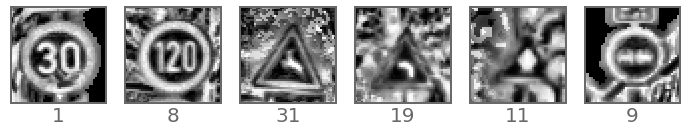

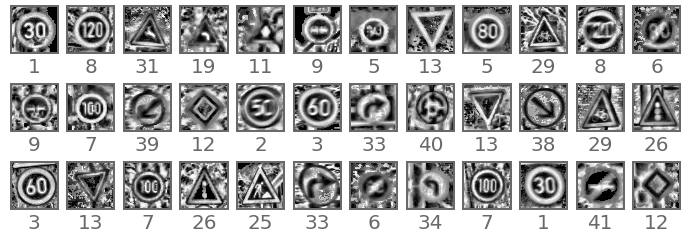

In [78]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

if img_lz>1:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(6),  columns=3,  x_size=4, y_size=3)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(36), columns=12, x_size=1, y_size=1)
else:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(6),  columns=6,  x_size=2, y_size=2)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model

In [79]:
batch_size  =  64
num_classes =  43
epochs      =  5

In [89]:

def get_model_v1():
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(img_lx, img_ly, img_lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Flatten()) 
#     model.add( keras.layers.Dense(3072, activation='relu'))
    model.add( keras.layers.Dense(500, activation='relu'))
    model.add( keras.layers.Dense(500, activation='relu'))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
def get_model_v2():
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(img_lx, img_ly, img_lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

def get_model_v3():
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', padding='same', input_shape=(img_lx, img_ly, img_lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


In [90]:
model = get_model_v3()

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 48, 48, 96)        960       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 24, 24, 96)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 24, 24, 96)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 24, 24, 192)       166080    
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 12, 12, 192)       0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 12, 12, 192)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 12, 12, 256)     

## 5/ Run model

In [91]:
%%time

history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))

Train on 39209 samples, validate on 12630 samples
Epoch 1/5
39209/39209 [==============================] - 6s 160us/sample - loss: 1.2276 - accuracy: 0.6518 - val_loss: 0.1684 - val_accuracy: 0.9474
Epoch 2/5
39209/39209 [==============================] - 6s 140us/sample - loss: 0.1075 - accuracy: 0.9666 - val_loss: 0.1226 - val_accuracy: 0.9625
Epoch 3/5
39209/39209 [==============================] - 5s 140us/sample - loss: 0.0603 - accuracy: 0.9819 - val_loss: 0.1489 - val_accuracy: 0.9572
Epoch 4/5
39209/39209 [==============================] - 5s 139us/sample - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.1102 - val_accuracy: 0.9687
Epoch 5/5
39209/39209 [==============================] - 5s 137us/sample - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.0998 - val_accuracy: 0.9727
CPU times: user 24.7 s, sys: 3.58 s, total: 28.3 s
Wall time: 28.1 s


## 6/ Evaluation

In [92]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.0998
Test accuracy  : 0.9727


---
### Results :  
set-24x24-L        : size=230 Mo, 90.67%  
set-24x24-L-LHE    : size=230 Mo, 93.90%  
set-24x24-RGB      : size=784 Mo, 92.82%  
set-24x24-RGB-HE   : size=784 Mo, 92.64%  
set-48x48-L-LHE    : size=230 Mo, 97.21%  (v2)
set-48x48-RGB-HE   : size=xxx Mo, 96.94%  (v2)
set-48x48-L-LHE    : size=784 Mo, 97.24%  (v3)

...